In [1]:
import pandas as pd
import numpy as np
from time import time
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import requests
#from pandas_profiling import ProfileReport
from sklearn.feature_selection import SelectKBest, SelectFromModel, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split,cross_val_predict, RandomizedSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix, classification_report, roc_curve, auc, plot_roc_curve, f1_score, roc_auc_score, balanced_accuracy_score,precision_score
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from scikitplot.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression,Perceptron,SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
import sklearn.metrics as metrics
import shap
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [2]:
data=pd.read_csv('train_data.csv')
data.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


**WE REPLACE  ΝΑΝ VALUES  MODE   'BED GRADE' & 'CITY CODE PATIENT'**

In [3]:
data['Bed Grade'].fillna(statistics.mode(data['Bed Grade']),inplace=True)
data['City_Code_Patient'].fillna(statistics.mode(data['City_Code_Patient']),inplace=True)

#### WE DROP THESE COLUMNS FROM THE DATA

In [4]:
data = data.drop(['Hospital_region_code', 'Bed Grade', 'patientid','case_id', 'City_Code_Patient'], axis = 1)

# LABEL ENCODER  

In [5]:
label = LabelEncoder()
data['Department'] = label.fit_transform(data['Department'])
data['Hospital_type_code'] = label.fit_transform(data['Hospital_type_code'])
data['Ward_Facility_Code'] = label.fit_transform(data['Ward_Facility_Code'])
data['Ward_Type'] = label.fit_transform(data['Ward_Type'])
data['Type of Admission'] = label.fit_transform(data['Type of Admission'])
data['Severity of Illness'] = label.fit_transform(data['Severity of Illness'])

In [6]:
age_dict = {'0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4, '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9}

In [7]:
data['Age'] = data['Age'].replace(age_dict.keys(), age_dict.values())

#### WE SEPERATE THE TARGET INTO '0-20' - '21-ABOVE' CLASSES .



In [8]:
#stay_dict = {'0-10': 0, '11-20': 1, '21-30': 2, '31-40': 2, '41-50': 2, '51-60': 2, '61-70': 2, '71-80': 2, '81-90': 2, '91-100': 2, 'More than 100 Days': 2}

In [9]:
stay_dict = {'0-10': 0, '11-20': 0, '21-30': 1, '31-40': 1, '41-50': 1, '51-60': 1, '61-70': 1, '71-80': 1, '81-90': 1, '91-100': 1, 'More than 100 Days': 1}

In [10]:
data['Stay'] = data['Stay'].replace(stay_dict.keys(), stay_dict.values())

<AxesSubplot:xlabel='Stay', ylabel='count'>

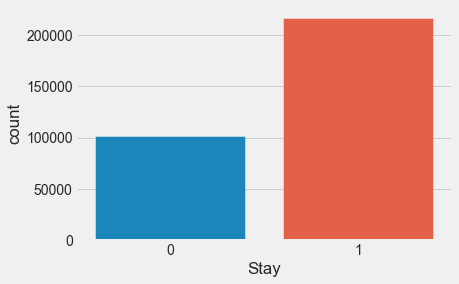

In [11]:
sns.countplot(x=data['Stay'], data=data)

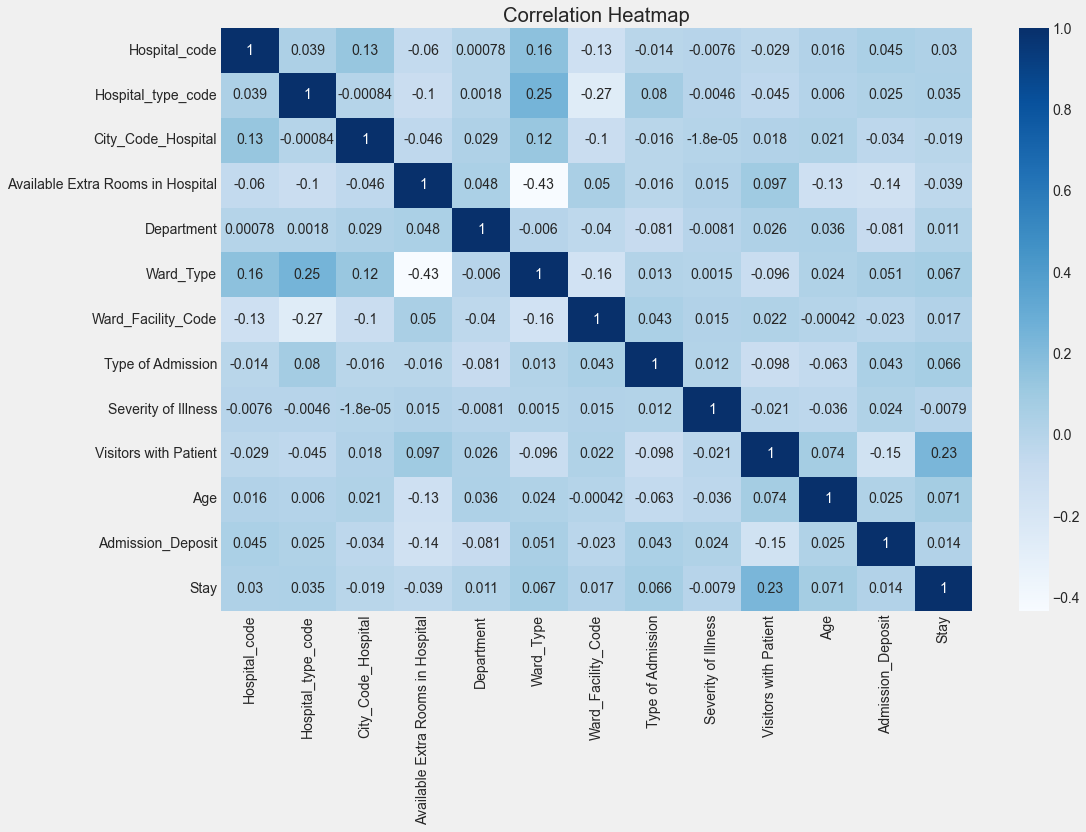

In [12]:
f, ax = plt.subplots(figsize=(15, 10))
plt.title("Correlation Heatmap")
ax=sns.heatmap(data.corr(), annot=True, fmt='.2g',cmap="Blues")

## NEW DATA


In [13]:
data

,Hospital_code,Hospital_type_code,City_Code_Hospital,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,2,3,3,3,2,5,0,0,2,5,4911.0,0
1,2,2,5,2,3,3,5,1,0,2,5,5954.0,1
2,10,4,1,2,1,3,4,1,0,2,5,4745.0,1
3,26,1,2,2,3,2,3,1,0,2,5,7272.0,1
4,26,1,2,2,3,3,3,1,0,2,5,5558.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,6,0,6,3,3,1,5,0,2,3,4,4144.0,0
318434,24,0,1,2,1,1,4,2,2,4,8,6699.0,1
318435,7,0,4,3,2,2,5,0,1,3,7,4235.0,0
318436,11,1,2,3,1,1,3,1,1,5,1,3761.0,0


### SPLIT THE DATA

In [14]:
X= data.drop('Stay', axis=1)
y= data['Stay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True,stratify=y)

### WE TRY SOME **CLASSIFIERS**

In [15]:
lr = LogisticRegression(multi_class='auto',class_weight='balanced',max_iter=300)
lr.fit(X_train, y_train)
y_pred_lr=lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
balanced_accuracy_score(y_test, y_pred_lr)

              precision    recall  f1-score   support

           0       0.41      0.67      0.51     20349
           1       0.78      0.55      0.65     43339

    accuracy                           0.59     63688
   macro avg       0.59      0.61      0.58     63688
weighted avg       0.66      0.59      0.60     63688



0.608752455965196

In [16]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))
balanced_accuracy_score(y_test, y_pred_knn)

              precision    recall  f1-score   support

           0       0.41      0.35      0.38     20349
           1       0.71      0.77      0.74     43339

    accuracy                           0.63     63688
   macro avg       0.56      0.56      0.56     63688
weighted avg       0.62      0.63      0.62     63688



0.5577498710629718

In [17]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100,class_weight='balanced')
random_forest.fit(X_train, y_train)
y_pred_RF = random_forest.predict(X_test)
print(classification_report(y_test, y_pred_RF))
balanced_accuracy_score(y_test, y_pred_RF)

              precision    recall  f1-score   support

           0       0.49      0.41      0.45     20349
           1       0.74      0.80      0.77     43339

    accuracy                           0.68     63688
   macro avg       0.62      0.61      0.61     63688
weighted avg       0.66      0.68      0.67     63688



0.6063267227562937

In [18]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred_DT = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred_DT))
balanced_accuracy_score(y_test, y_pred_DT)

              precision    recall  f1-score   support

           0       0.44      0.45      0.45     20349
           1       0.74      0.73      0.73     43339

    accuracy                           0.64     63688
   macro avg       0.59      0.59      0.59     63688
weighted avg       0.64      0.64      0.64     63688



0.5903635118260445

<AxesSubplot:>

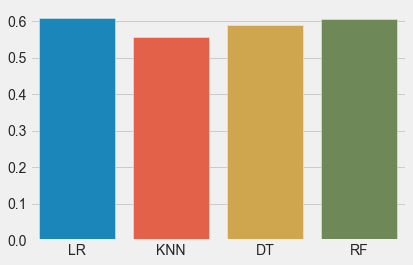

In [19]:
sns.barplot(x= ['LR','KNN','DT','RF'],y= [balanced_accuracy_score(y_test, y_pred_lr),
                                          balanced_accuracy_score(y_test, y_pred_knn), 
                                          balanced_accuracy_score(y_test, y_pred_DT),
                                          balanced_accuracy_score(y_test, y_pred_RF)])

### FEATURE IMPORTANCE


In [20]:
#random_forest

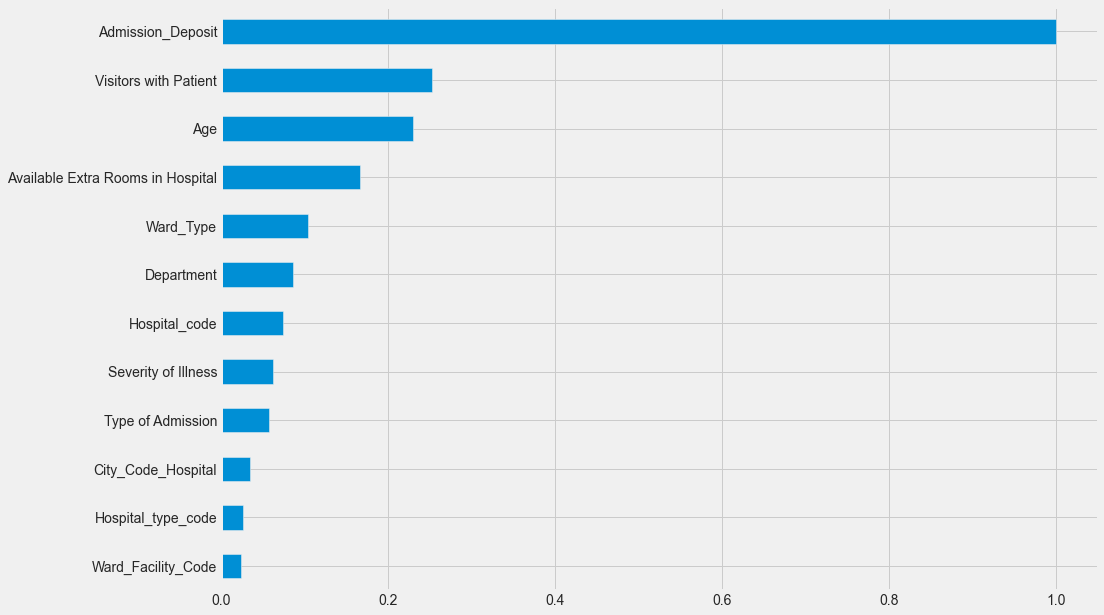

In [21]:
importance = pd.Series(random_forest.feature_importances_, index=list(X))
importance = importance/importance.max()
importance = importance.sort_values(ascending=False).head(20)
importance.sort_values().plot.barh(figsize=(14,10))
plt.show()

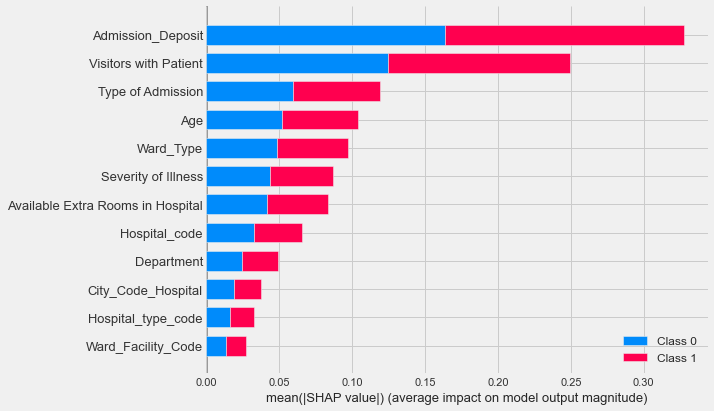

In [22]:
shap_values = shap.TreeExplainer(random_forest).shap_values(X_train, approximate=True)
shap.summary_plot(shap_values, X_train, plot_type="bar")

### OVERSAMPLING WITH SMOTE

In [23]:
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

the sample before smote: 1    173356
0     81394
Name: Stay, dtype: int64
the sample after smote: 0    173356
1    173356
Name: Stay, dtype: int64


<AxesSubplot:xlabel='Stay', ylabel='count'>

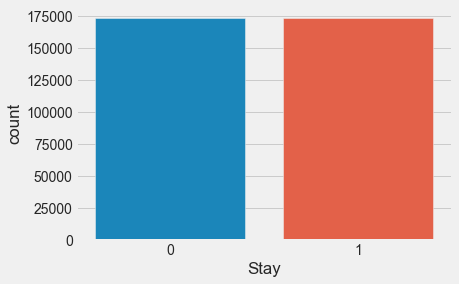

In [24]:
print(f'the sample before smote: {y_train.value_counts()}')
print(f'the sample after smote: {y_train_smote.value_counts()}')
sns.countplot(x=y_train_smote , data=data)

In [25]:
lr = LogisticRegression(class_weight='balanced',max_iter=300)
lr.fit(X_train_smote, y_train_smote)
y_pred_lr=lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
balanced_accuracy_score(y_test, y_pred_lr)

              precision    recall  f1-score   support

           0       0.42      0.57      0.48     20349
           1       0.76      0.63      0.69     43339

    accuracy                           0.61     63688
   macro avg       0.59      0.60      0.58     63688
weighted avg       0.65      0.61      0.62     63688



0.5975866461246427

In [26]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_smote, y_train_smote)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))
balanced_accuracy_score(y_test, y_pred_knn)

              precision    recall  f1-score   support

           0       0.40      0.52      0.45     20349
           1       0.74      0.63      0.68     43339

    accuracy                           0.59     63688
   macro avg       0.57      0.57      0.56     63688
weighted avg       0.63      0.59      0.61     63688



0.5745748417428456

In [27]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100,class_weight='balanced')
random_forest.fit(X_train_smote, y_train_smote)
y_pred_RF = random_forest.predict(X_test)
print(classification_report(y_test, y_pred_RF))
balanced_accuracy_score(y_test, y_pred_RF)

              precision    recall  f1-score   support

           0       0.47      0.54      0.50     20349
           1       0.77      0.72      0.74     43339

    accuracy                           0.66     63688
   macro avg       0.62      0.63      0.62     63688
weighted avg       0.67      0.66      0.66     63688



0.6274378383917001

In [28]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_smote, y_train_smote)
y_pred_DT = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred_DT))
balanced_accuracy_score(y_test, y_pred_DT)

              precision    recall  f1-score   support

           0       0.43      0.51      0.47     20349
           1       0.75      0.68      0.72     43339

    accuracy                           0.63     63688
   macro avg       0.59      0.60      0.59     63688
weighted avg       0.65      0.63      0.64     63688



0.5988885551682543

<AxesSubplot:>

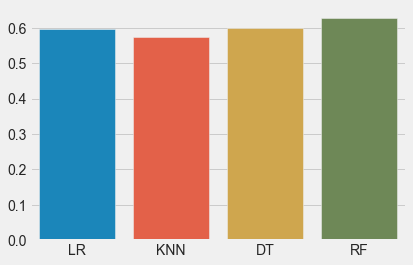

In [29]:
sns.barplot(x= ['LR','KNN','DT','RF'],y= [balanced_accuracy_score(y_test, y_pred_lr),
                                          balanced_accuracy_score(y_test, y_pred_knn), 
                                          balanced_accuracy_score(y_test, y_pred_DT),
                                          balanced_accuracy_score(y_test, y_pred_RF)])

### we see with oversampling that RandomForest is a little better

# WE WILL TRY WITH DUMMIES 

In [30]:
data_dummies=pd.read_csv('train_data.csv')
data_dummies

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.0,86499,23.0,Emergency,Moderate,3,41-50,4144.0,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.0,325,8.0,Urgent,Moderate,4,81-90,6699.0,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.0,125235,10.0,Emergency,Minor,3,71-80,4235.0,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.0,91081,8.0,Trauma,Minor,5,11-20,3761.0,11-20


In [31]:
data_dummies['Bed Grade'].fillna(statistics.mode(data_dummies['Bed Grade']),inplace=True)
data_dummies['City_Code_Patient'].fillna(statistics.mode(data_dummies['City_Code_Patient']),inplace=True)

In [32]:
data_dummies = data_dummies.drop(['patientid','case_id'], axis = 1) #'Hospital_region_code', 'Bed Grade','City_Code_Patient'

In [33]:
#age_dict = {'0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4, '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9}

In [34]:
#data_dummies['Age'] = data_dummies['Age'].replace(age_dict.keys(), age_dict.values())

In [35]:
stay_dict = {'0-10': 0, '11-20': 0, '21-30': 1, '31-40': 1, '41-50': 1, '51-60': 1, '61-70': 1, '71-80': 1, '81-90': 1, '91-100': 1, 'More than 100 Days': 1}

In [36]:
data_dummies['Stay'] = data_dummies['Stay'].replace(stay_dict.keys(), stay_dict.values())

In [37]:
data_dummies=pd.get_dummies(data_dummies)
data_dummies.head()

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,City_Code_Patient,Visitors with Patient,Admission_Deposit,Stay,Hospital_type_code_a,Hospital_type_code_b,...,Age_0-10,Age_11-20,Age_21-30,Age_31-40,Age_41-50,Age_51-60,Age_61-70,Age_71-80,Age_81-90,Age_91-100
0,8,3,3,2.0,7.0,2,4911.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,5,2,2.0,7.0,2,5954.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,10,1,2,2.0,7.0,2,4745.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,26,2,2,2.0,7.0,2,7272.0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,26,2,2,2.0,7.0,2,5558.0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
data_dummies.info()

### SPLIT THE dummies DATASET

In [38]:
X_dummies= data_dummies.drop(['Stay'], axis=1)
y_dummies= data_dummies['Stay']

X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(X_dummies, y_dummies, test_size=0.2, random_state=42, shuffle=True)

### we try with RandomForest because is our best choice as we saw before

In [39]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=42,n_jobs=-1)
random_forest.fit(X_train_dummies, y_train_dummies)
y_pred_RF_dummies = random_forest.predict(X_test_dummies)

print(classification_report(y_test_dummies, y_pred_RF_dummies))
balanced_accuracy_score(y_test_dummies, y_pred_RF_dummies)

              precision    recall  f1-score   support

           0       0.55      0.42      0.47     20250
           1       0.76      0.84      0.80     43438

    accuracy                           0.71     63688
   macro avg       0.65      0.63      0.64     63688
weighted avg       0.69      0.71      0.69     63688



0.6291534771568843

### oversample with smote

In [40]:
sm = SMOTE(random_state=42)
X_train_dummies_smote, y_train_dummies_smote = sm.fit_resample(X_train_dummies, y_train_dummies)

In [41]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=42,n_jobs=-1)
random_forest.fit(X_train_dummies_smote, y_train_dummies_smote)
y_pred_RF_dummies_smote = random_forest.predict(X_test_dummies)

print(classification_report(y_test_dummies, y_pred_RF_dummies_smote))
balanced_accuracy_score(y_test_dummies, y_pred_RF_dummies_smote)

              precision    recall  f1-score   support

           0       0.54      0.45      0.49     20250
           1       0.76      0.82      0.79     43438

    accuracy                           0.70     63688
   macro avg       0.65      0.63      0.64     63688
weighted avg       0.69      0.70      0.69     63688



0.6332457272718488

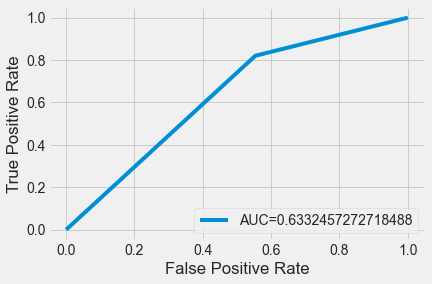

In [42]:
fpr, tpr, _ = metrics.roc_curve(y_test_dummies, y_pred_RF_dummies_smote)
auc = metrics.roc_auc_score(y_test_dummies, y_pred_RF_dummies_smote)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The more that the curve hugs the top left corner of the plot, the better the model does at classifying the data into categories

To quantify this, we can calculate the AUC – area under the curve – which tells us how much of the plot is located under the curve

The max is 1 so it is a good model that needs more improvement

### we will use stratify with RandomizedSearchCV to find the best parameters by different tries!!

In [44]:
X_dummies= data_dummies.drop(['Stay'], axis=1)
y_dummies= data_dummies['Stay']

In [ ]:
#X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(X_dummies, y_dummies, test_size=0.2, random_state=42, stratify=y)

we cant improve the model yet  and we need more tries !

In [49]:
Models = pd.DataFrame(columns=['Algorithm','Model Score','Precision','Recall','F1 score','ROC-AUC score'])

def taining_without_feature_selection(Parameters, Model, Dataframe, Modelname):
    
    train = Dataframe.copy()
    
    X = train.drop(['Stay'], axis=1)
    y = train['Stay']
    
    #Traditional split of the dataset 80% - 20%
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

    #Proportional split of 80% data with respect to the class of the target feature ie. [1,0]
    sf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    print(f'StratifiedKFold and sf is: {sf}')
    print(sf.split(x_train, y_train))

    for train_index, test_index in sf.split(x_train, y_train):
#         print(train_index)
#         print(test_index)
        sf_x_train, sf_x_test = X.iloc[train_index], X.iloc[test_index]
        sf_y_train, sf_y_test = y.iloc[train_index], y.iloc[test_index]
        
    sf_x_train, sf_x_test, sf_y_train, sf_y_test = sf_x_train.values, sf_x_test.values, sf_y_train.values, sf_y_test.values
    
    model_parameter_sm = Parameters

    rand_model = RandomizedSearchCV(Model, model_parameter_sm, n_iter=4)
    print(f'our RandomizedSearchCV :rand_model is:{rand_model}')
     
    #Identifying the best parameters through RandomizedSearchCV()
    for train, test in sf.split(sf_x_train, sf_y_train):
        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_model) 
        fitting_model = pipeline.fit(sf_x_train[train], sf_y_train[train])
        best_model = rand_model.best_estimator_
        print(best_model)

    #Evaluation with against 20% unseen testing data
    print()
    print("Evaluation Of Models")  

    sm = SMOTE(sampling_strategy='minority', random_state=42)
    Xsm_train, ysm_train = sm.fit_resample(sf_x_train, sf_y_train)
    print()
    print("Random Model Evaluation")  
    
    final_model_sm = rand_model.best_estimator_
    print(f'final model with best estimator is :{final_model_sm}')
    final_model_sm.fit(Xsm_train, ysm_train)

    prediction = final_model_sm.predict(sf_x_test)

    #confusion matrix
    cf_matrix = confusion_matrix(sf_y_test , prediction)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
    #classification_report
    print(classification_report(sf_y_test , prediction,target_names=['class 0:20 days', 'class 20:above days']))
    
    #create ROC curve
    fpr, tpr, _ = metrics.roc_curve(sf_y_test , prediction)
    auc = metrics.roc_auc_score(sf_y_test , prediction)

    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.title('ROC Plot')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    
    Model = {}

    Model['Algorithm'] = Modelname
    Model['Model Score'] = str(round((accuracy_score(sf_y_test , prediction)*100),2)) + "%"
    Model['Precision'] = round(precision_score(sf_y_test , prediction),2)
    Model['Recall'] = round(recall_score(sf_y_test , prediction),2)
    Model['F1 score'] = round(f1_score(sf_y_test , prediction),2)
    Model['ROC-AUC score'] = round(roc_auc_score(sf_y_test , prediction),2)
    print(Model)
    return Model

In [50]:
# Number of trees in random forest
n_estimators = [200,500]  #[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto']  #'sqrt'
# Maximum number of levels in tree
max_depth = [10,20,30]   #int(x) for x in np.linspace(10, 110, num = 11)
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5,10]  #10
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4]  #4
# Method of selecting samples for training each tree
bootstrap = [True,False] #True
# Create the random grid
model_parameter_sm  = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}

RandomForest
StratifiedKFold and sf is: StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
<generator object _BaseKFold.split at 0x000001F900D8BF90>
our RandomizedSearchCV :rand_model is:RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 500]})
RandomForestClassifier(max_depth=30, min_samples_split=10, n_estimators=200)
RandomForestClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=500)
RandomForestClassifier(max_depth=30, min_samples_leaf=4, n_estimators=200)
RandomForestClassifier(max_depth=30, min_samples_lea

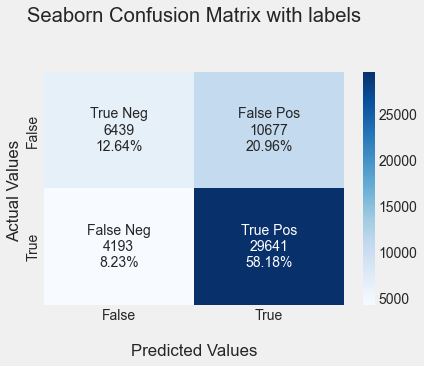

                     precision    recall  f1-score   support

    class 0:20 days       0.61      0.38      0.46     17116
class 20:above days       0.74      0.88      0.80     33834

           accuracy                           0.71     50950
          macro avg       0.67      0.63      0.63     50950
       weighted avg       0.69      0.71      0.69     50950



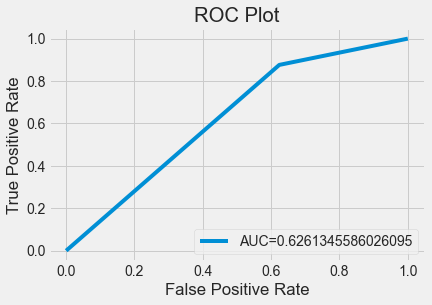

{'Algorithm': 'RandomForest', 'Model Score': '70.81%', 'Precision': 0.74, 'Recall': 0.88, 'F1 score': 0.8, 'ROC-AUC score': 0.63}


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [51]:
print("RandomForest")
TrainedModel = taining_without_feature_selection(model_parameter_sm, 
                                                 RandomForestClassifier(), 
                                                 data_dummies,
                                                 "RandomForest")
Models = Models.append(TrainedModel,ignore_index=True)